### 회고(하은): 
- 배운 점:
    - ControlNet을 다중으로 사용할 때는 controlnets의 순서와 image= 인풋의 순서가 정확히 1:1 대응되어야 포즈의 정보를 올바르게 참고하여 이미지를 생성할 수 있다는 것을 배웠다. 아니면 반대로 인식하게 되어 이미지에 openpose의 라인이 남고 아무리 프롬프트를 수정해도 원하는 이미지를 생성해 낼 수 없게 된다.
- 아쉬운 점: 
    - 커널이 자주 중단되기도 하고 코랩에서 하면 GPU 메모리 이슈도 있고해서 이미지를 다양하게 생성해보지 못해서 아쉬웠다.
- 느낀 점: 
    - 예상했던 대로 생성된 사람의 이미지가 기기괴괴하고, 한 두번의 프롬프트 수정으로 원하는 이미지를 생성하는 데는 무리가 있다는 것을 느꼈다.
- 어려웠던 점: 
    - 이미지를 여러 번 생성할 때는 기존의 이미지를 기반으로 할 것인지 아니면 전에 생성된 이상한 이미지를 기반으로 생성할 것인지에 따라 크케 차이가 난다. 근데 이상하게 왜곡된 이미지에 다시 프롬프트를 수정해서 생성해도 바로 잡히지 않는다는 사실을 너무 늦게 알았다. 

## 회고 (승아)

### 배운점
- 디퓨전 모델 기반 COMFYUI 등은 써봤는데, 원리와 아이데이션을 알게 되었다.  

### 느낀점
- 디퓨전 모델이나, 딥러닝, GPT 등 새로운 모델을 만들거나 개선하는 아이데이션 방법이 너무 신기하다. 천재인듯. 
- 코랩에서 메모리 이슈로 계속 쫓겨나 결국 모델 버전 낮춰서 왔더니 결과가 이상하게 나옴. 역시 프롬프트고 코드고 뭐고, 모델을 좋은 것 + 최신으로 쓰는게 최고다. 

### 아쉬운점
- 코랩에선 메모리 이슈, 아이펠 노드에서는 호환성 이슈로 제대로 된 결과물을 내기 힘들었다. 
- 좋은 로컬 세팅을 해서 제대로 실험해보고싶다.

## 필요한 라이브러리 설치

In [2]:
# Stable Diffusion 설치
!pip install -qq diffusers==0.31

### CUDA out of memery가 나올 때, 메모리 삭제용 코드

## 1. 윤곽선 검출
### - 가장 유명하고 효과적인 윤곽선 검출 알고리즘인 **Canny 알고리즘을 사용**

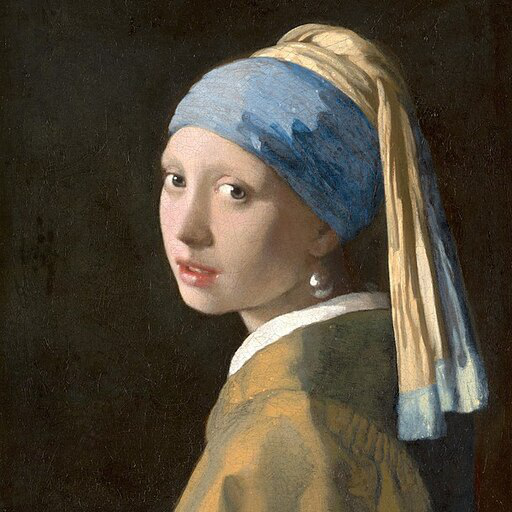

In [14]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

In [15]:
# 메모리 삭제
torch.cuda.empty_cache()

### OpenCV를 사용하여 이미지의 윤곽선을 검출한다.

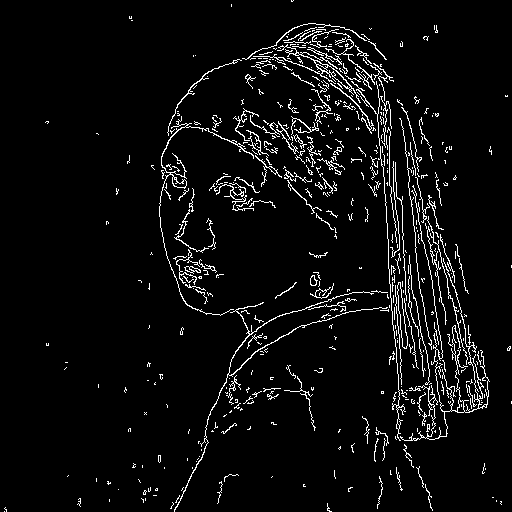

In [16]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

### 윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러온다.

In [17]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### 윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지를 생성해 보기.

  0%|          | 0/20 [00:00<?, ?it/s]

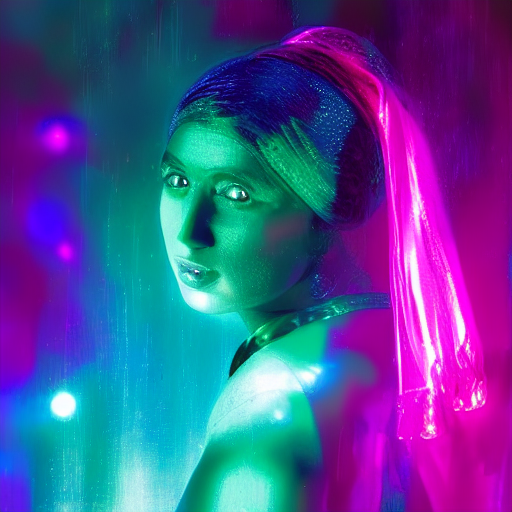

In [18]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image_1 = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image_1.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image_1

## - 다양한 시도(1)
### - 프롬프트 외에도 부정적인 프롬프트(negative_propmt)를 넣을 수도 있고, 하이퍼파라미터를 조절할 수도 있음.
    - negative_propmt: 원하지 않는 요소를 적을 수 있습니다.
    - controlnet_conditioning_scale: ContorlNet으로 조건을 어느 정도 주느냐를 조절합니다. Default는 1이고, 실수값으로 설정할 수 있습니다.
    - num_inference_steps: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸립니다. default 값은 50입니다.
    - guidance_scale: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있습니다. default는 7.5입니다.

  0%|          | 0/40 [00:00<?, ?it/s]

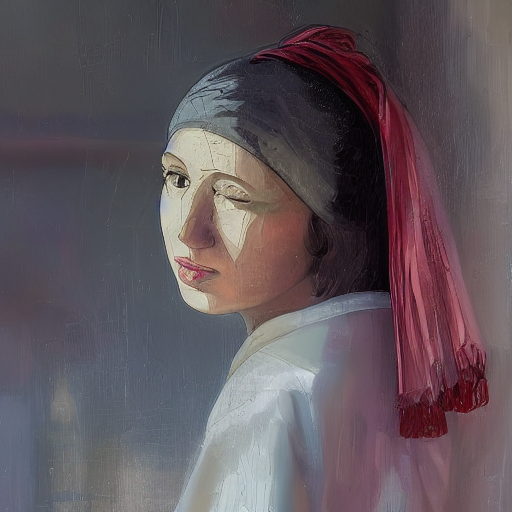

In [19]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image_2 = canny_pipe(
    prompt="A barista in the soft sunlight", 
    negative_propmt = "cloudy",
    num_inference_steps=40, 
    guidance_scale = 6.0,
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image_2.save("/aiffel/aiffel/canny_image2.png")  

# 생성된 이미지를 출력합니다. 
canny_image_2

  0%|          | 0/50 [00:00<?, ?it/s]

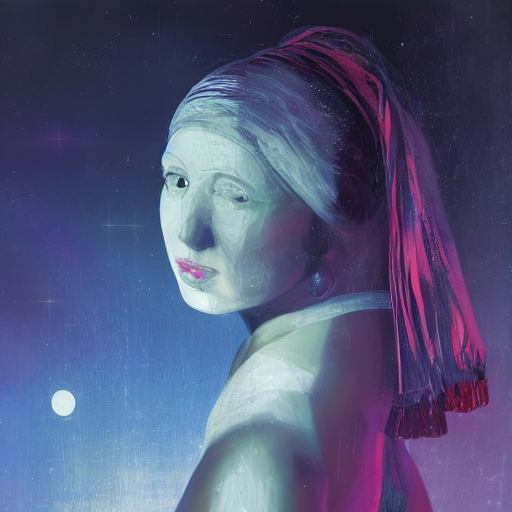

In [21]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image_3 = canny_pipe(
    prompt="a woman dancing under the light of the moon", 
#     negative_propmt = "man, animal",
    num_inference_steps=50, 
    guidance_scale = 7.5,
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image_3.save("/aiffel/aiffel/canny_image3.png")  

# 생성된 이미지를 출력합니다. 
canny_image_3

  0%|          | 0/50 [00:00<?, ?it/s]

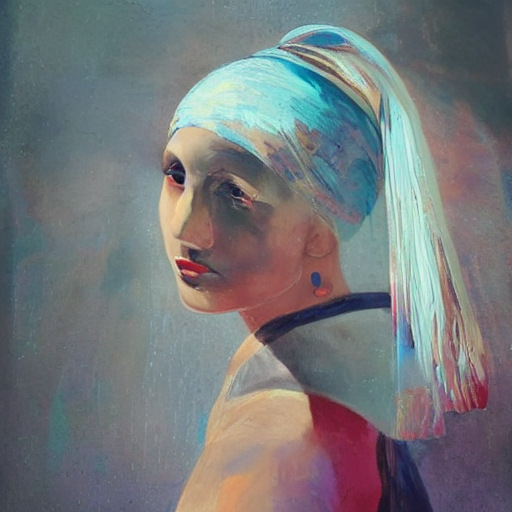

In [22]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(3)  

# 이미지를 생성합니다. 
canny_image_4 = canny_pipe(
    prompt="a woman dancing under the light of the moon", 
    negative_propmt = "a poker face",
    num_inference_steps=50, 
    guidance_scale = 5.5,
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image_4.save("/aiffel/aiffel/canny_image4.png")  

# 생성된 이미지를 출력합니다. 
canny_image_4

## 2. 인체 자세 감지
- Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기.
- 자세를 감지하여 새로운 이미지를 생성해 준다.

### 사람의 전신이 담긴 이미지를 불러온다.

In [23]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 64 kB 3.0 MB/s             


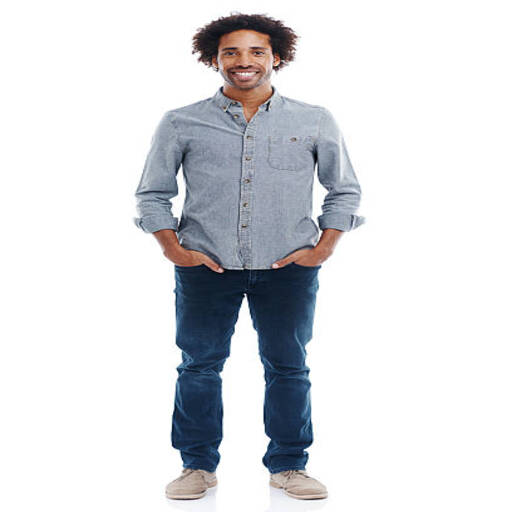

In [24]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

### Openpose 검출기를 사용하면 자세만 추출

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


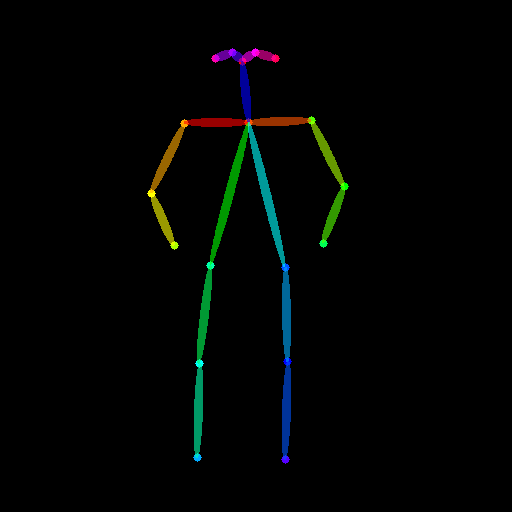

In [25]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

### Openpose 전처리기를 사용한 모델 파이프라인을 불러온다.

In [26]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### 새로운 이미지를 생성해 보기. 
- 

  0%|          | 0/50 [00:00<?, ?it/s]

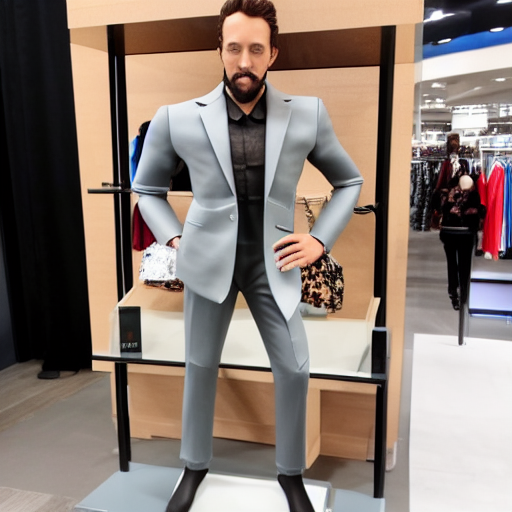

In [27]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

#프롬프트를 작성합니다. 
prompt =  "Model displayed at department store showcase"
negative_prompt = "intense light"

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

  0%|          | 0/30 [00:00<?, ?it/s]

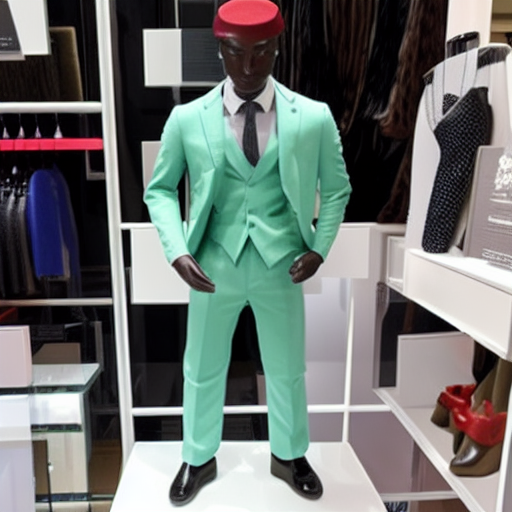

In [28]:
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

#프롬프트를 작성합니다. 
prompt =  "Model displayed at department store showcase"
negative_prompt = "intense light"

# 이미지를 생성합니다. 
openpose_image2 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=1.0,   # 보통 0.5 ~ 2.0 사이에서 조정
    num_inference_steps=30,
    generator=generator,
    image=openpose_image                # ← OpenPose 조건 이미지 입력
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image2

  0%|          | 0/30 [00:00<?, ?it/s]

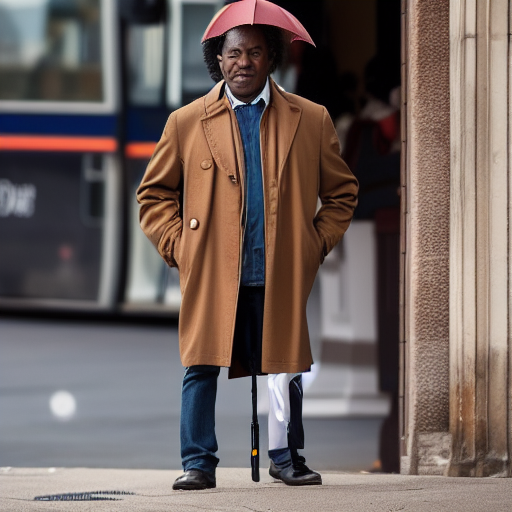

In [29]:
from diffusers import UniPCMultistepScheduler
import torch

# 스케줄러 교체 & 모델을 CUDA로 이동
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 고정
generator = torch.manual_seed(0)

# 프롬프트 설정
prompt = "light brown, holdding an umbrella, at bus stop"
negative_prompt = "low quality, blurry, distorted, deformed"

# 이미지 생성
openpose_image3 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=1.5,   # 보통 0.5 ~ 2.0 사이에서 조정
    num_inference_steps=30,
    generator=generator,
    image=openpose_image                # ← OpenPose 조건 이미지 입력
).images[0]

# 이미지 출력
openpose_image3

## 3. 윤곽선 검출 + 인체 자세 감지
### Canny 알고리즘을 사용한 윤곽선 검출
- Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의

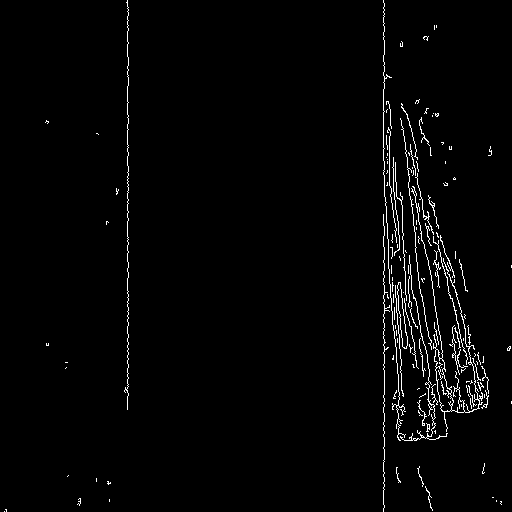

In [30]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
canny_image = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")
canny_image = canny_image.resize((512, 512))

#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. GRAYSCALE로 변경.
canny_image = np.array(canny_image.convert("L"))

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold) # Canny 엣지 검출
canny_image = np.stack([canny_image] * 3, axis= -1)
canny_image = Image.fromarray(canny_image)

canny_image

cuda


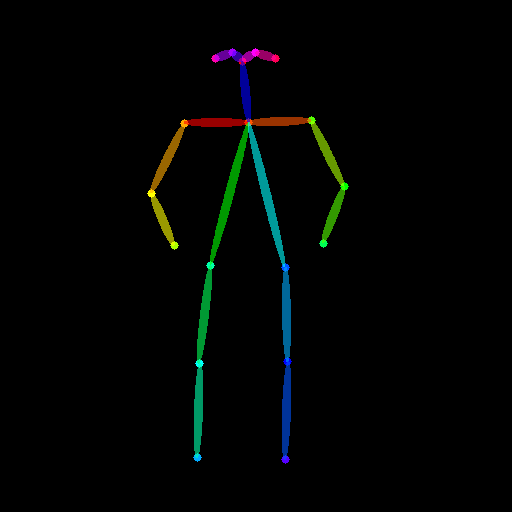

In [31]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
openpose_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)
openpose_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

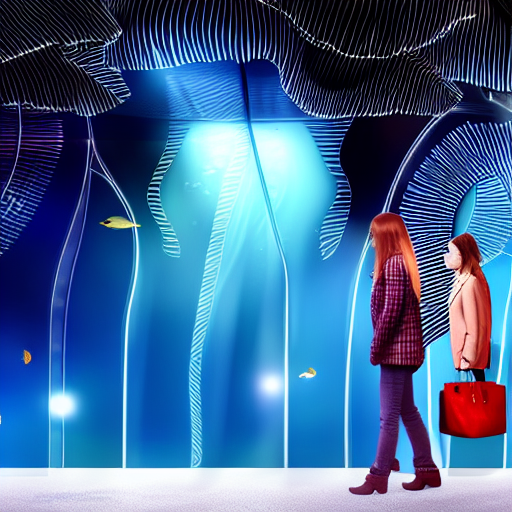

In [34]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "A woman walking in an aquarium, fairy tale, ultra detailed, 4k"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# seed를 지정합니다. 
generator = torch.manual_seed(0)

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image_1 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
image_1.save("/aiffel/aiffel/multi_controlnet_output_1.png")

# 생성된 이미지를 출력합니다.  
image_1

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

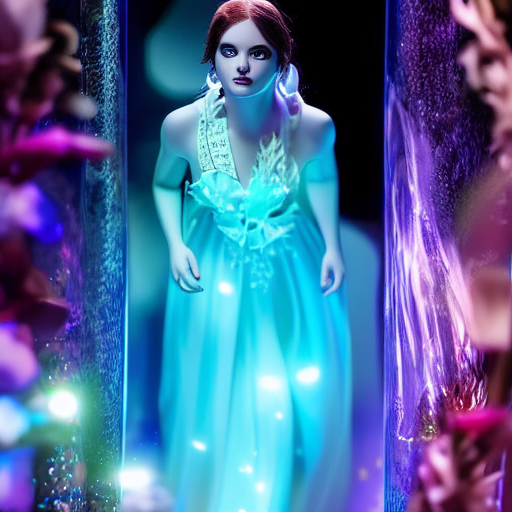

In [35]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "A woman walking in an aquarium, fairy tale, ultra detailed, 4k"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# seed를 지정합니다. 
generator = torch.manual_seed(0)

images = [canny_image, openpose_image]

# 이미지를 생성합니다. 
image_2 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
# image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output1.png")
image_2.save("/aiffel/aiffel/multi_controlnet_output_2.png")


# 생성된 이미지를 출력합니다.  
image_2

현재 업로드해주신 이미지들을 바탕으로 보면, ControlNet이 OpenPose 이미지로부터 포즈 정보를 제대로 반영하지 않고, 대신 어떤 배경 이미지 중심에 강하게 반영된 라인 형태가 결과 이미지에 나타난 것으로 보입니다.

📸 문제 요약
openpose_image는 명확한 단일 인물의 포즈 정보를 담고 있음에도,

생성된 이미지에서는 **가운데 굵은 선(라인)**이 강조되고 인물의 포즈는 직접적으로 반영되지 않았어요.

❓왜 이런 일이 발생했을까?
🎯 가능성 1: 이미지 입력 순서가 pipe() 함수에서 반대로 들어감
ControlNet을 다중으로 사용할 때는 controlnets의 순서와 image= 인풋의 순서가 정확히 1:1 대응되어야 합니다.

    - controlnet_canny가 첫 번째인데 그에 해당하는 조건 이미지가 openpose_image로 들어가고 있는 것, 즉 이미지 순서가 뒤바뀐 것이 원인일 가능성이 매우 높습니다.
🎯 가능성 2: OpenPose 전처리 이미지가 잘못된 형식일 수 있음
openpose_image가 흑백 PNG 또는 알파 채널 포함 RGBA 형식이라면, 모델이 이를 RGB 입력으로 해석하지 못할 수 있어요.

🎯 가능성 3: ControlNet에 대한 영향력 (conditioning scale)이 낮거나 잘못 설정됨.


In [6]:
# Stable Diffusion 설치
!pip install -qq diffusers==0.31
!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 64 kB 3.1 MB/s             


In [7]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from controlnet_aux import OpenposeDetector
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

In [3]:
# 포즈 이미지 링크
# https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyNTA0MDhfOTUg%2FMDAxNzQ0MDg5NDM2MDEz.U_29wsnZTiXTfKK2BQFH5wvGEpGrWm4a7ax31vKdN1og.Feox-RLfweok-LbCgTFyBiFvHMNU3rUkPh4yKM-CYEAg.PNG%2Fimage.png&type=sc960_832
# 윤곽선 이미지 링크
# https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAxNzA3MTdfMTA1%2FMDAxNTAwMjk2MDA5NDgz.CJ70rm-KOC4QE1g_6Ug-rLMhVHYZR2T15s7GxIXMyXIg.W4-Lw815IalxHG2jJPubvdNz_a7P1OXpVAKyZN5Vbtsg.JPEG.alsdk0404%2F62684637_p0.jpg&type=sc960_832

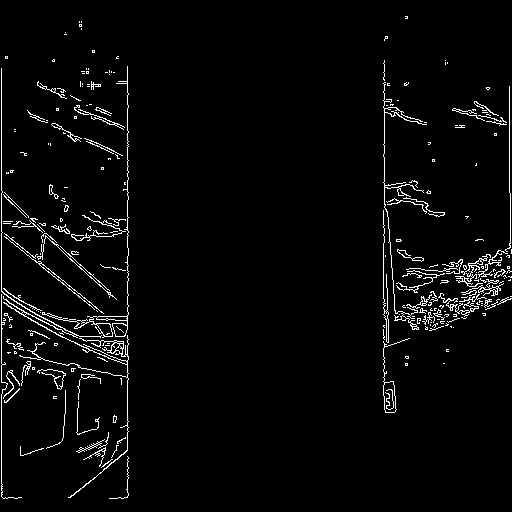

In [8]:
# 이미지를 불러오기.
canny_image = load_image("https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAxNzA3MTdfMTA1%2FMDAxNTAwMjk2MDA5NDgz.CJ70rm-KOC4QE1g_6Ug-rLMhVHYZR2T15s7GxIXMyXIg.W4-Lw815IalxHG2jJPubvdNz_a7P1OXpVAKyZN5Vbtsg.JPEG.alsdk0404%2F62684637_p0.jpg&type=sc960_832")
canny_image = canny_image.resize((512, 512))

#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. GRAYSCALE로 변경.
canny_image = np.array(canny_image.convert("L"))

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold) # Canny 엣지 검출
canny_image = np.stack([canny_image] * 3, axis= -1)
canny_image = Image.fromarray(canny_image)

canny_image

cuda


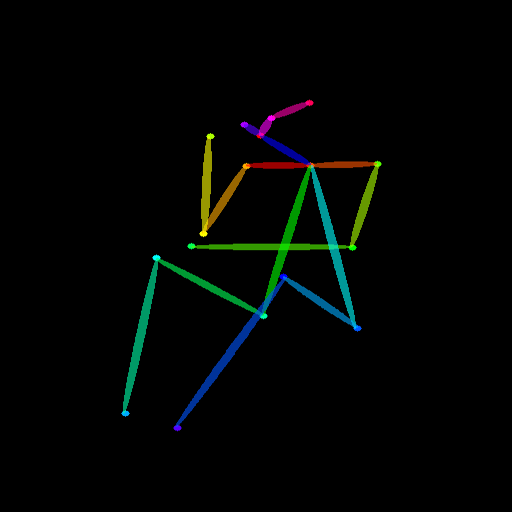

In [12]:
# 이미지를 불러옵니다. 
openpose_image = load_image("https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyNTA0MDhfOTUg%2FMDAxNzQ0MDg5NDM2MDEz.U_29wsnZTiXTfKK2BQFH5wvGEpGrWm4a7ax31vKdN1og.Feox-RLfweok-LbCgTFyBiFvHMNU3rUkPh4yKM-CYEAg.PNG%2Fimage.png&type=sc960_832")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)
openpose_image = openpose_image.resize((512, 512))
openpose_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

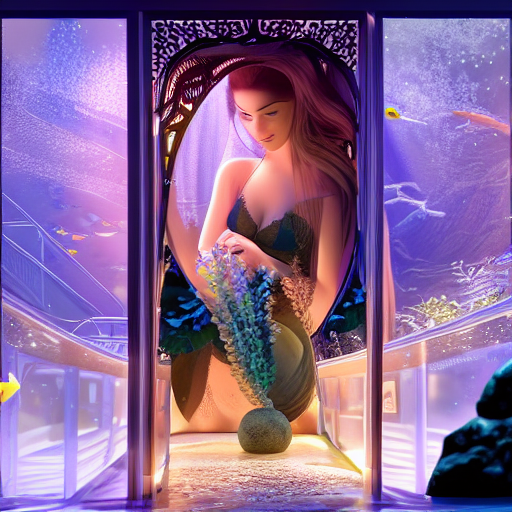

In [21]:
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "A woman in an aquarium, fairy tale, ultra detailed, 4k"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# seed를 지정합니다. 
generator = torch.manual_seed(1)

images = [canny_image, openpose_image]

# 이미지를 생성합니다. 
image_4 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
# image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output1.png")
image_4.save("/aiffel/aiffel/multi_controlnet_output_4.png")


# 생성된 이미지를 출력합니다.  
image_4

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

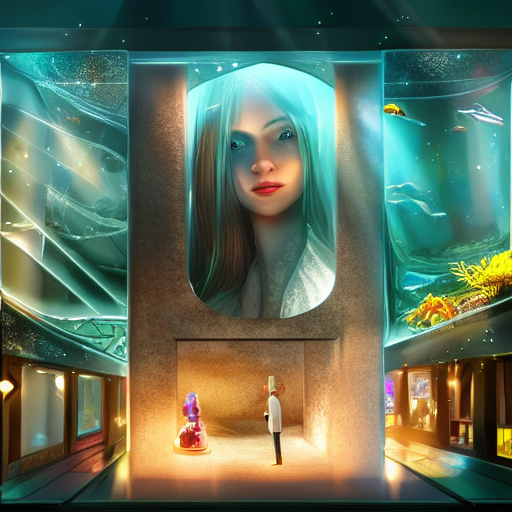

In [26]:
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "A fantasy aquarium with magical lights and a walking woman, soft lighting, ultra detailed"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# seed를 지정합니다. 
generator = torch.manual_seed(2)

images = [canny_image, openpose_image]

# 이미지를 생성합니다. 
image_6 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
# image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output1.png")
image_6.save("/aiffel/aiffel/multi_controlnet_output_6.png")


# 생성된 이미지를 출력합니다.  
image_6

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

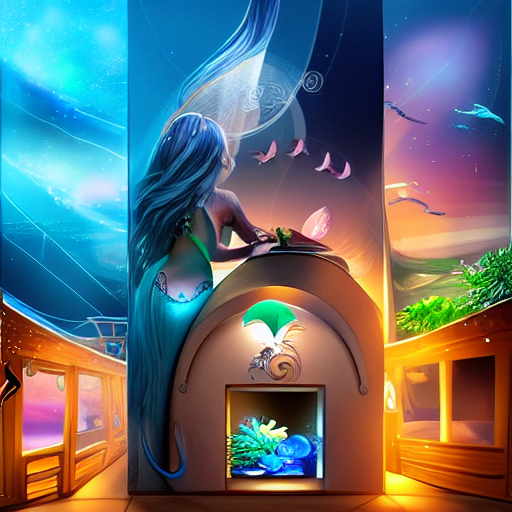

In [27]:
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "A fantasy aquarium with magical lights and a mermaid, soft lighting, cartoon style, ultra detailed"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# seed를 지정합니다. 
generator = torch.manual_seed(7)

images = [canny_image, openpose_image]

# 이미지를 생성합니다. 
image_7 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
# image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output1.png")
image_7.save("/aiffel/aiffel/multi_controlnet_output_7.png")


# 생성된 이미지를 출력합니다.  
image_7